Initial MI trials: 2400

STAGE 0: DETECTING DUPLICATE SESSIONS
Computing session hashes...


100%|██████████| 240/240 [00:12<00:00, 18.90it/s]


Duplicate group: ['S19-7', 'S9-7']
  Keeping: S19-7
  Removing: ['S9-7']
Duplicate group: ['S21-6', 'S5-6']
  Keeping: S21-6
  Removing: ['S5-6']
Duplicate group: ['S29-6', 'S8-6']
  Keeping: S29-6
  Removing: ['S8-6']
Duplicate group: ['S29-7', 'S3-7']
  Keeping: S29-7
  Removing: ['S3-7']

Removed 40 trials from duplicate sessions
Remaining trials: 2360
Computing adaptive thresholds from data sample...


100%|██████████| 2360/2360 [04:03<00:00,  9.71it/s]



=== ADAPTIVE THRESHOLDS ===
Amplitude threshold: 456654.44 μV
Variance threshold: 0.000000 μV²
Feature dimensions: (2360, 16)

STAGE 1: DETECTING SEVERE ARTIFACTS


100%|██████████| 2360/2360 [08:56<00:00,  4.40it/s]



Stage 1 removed 337 trials
Remaining trials: 2023

STAGE 2: MULTIVARIATE OUTLIER DETECTION


100%|██████████| 2023/2023 [18:12<00:00,  1.85it/s]



Stage 2 removed 1248 trials
Remaining trials: 775

SESSION-LEVEL OUTLIER REMOVAL
Removed 0 trials from outlier sessions
Remaining trials: 775

SUBJECT-LEVEL OUTLIER REMOVAL
Removed 0 trials from outlier subjects
Final dataset size: 775 trials

FINAL QUALITY REPORT
Original trials: 2400
Final trials: 775
Total removed: 1625 (67.7%)
Subjects retained: 22/30
Sessions retained: 8/8

Outlier removal complete! Check output directory for reports.


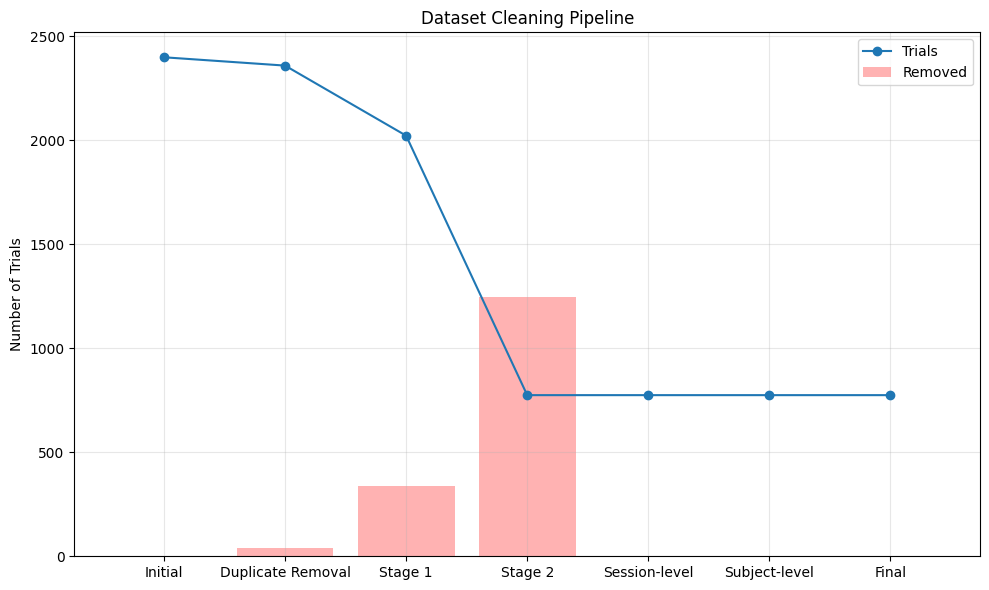

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.signal import butter, filtfilt, welch
from sklearn.covariance import MinCovDet
from tqdm import tqdm
import warnings
import hashlib

# Suppress warnings
warnings.filterwarnings('ignore')

# ==============================
# CONFIGURATION
# ==============================
class Config:
    BASE_PATH = '/kaggle/input/mtcaic3-phase-ii'
    TASK = 'MI'
    EEG_CHANNELS = ['FZ', 'C3', 'CZ', 'C4', 'PZ', 'PO7', 'OZ', 'PO8']
    SAMPLING_RATE = 250
    STIM_PERIOD = (3.5, 7.5)  # Seconds (MI stimulation window)
    OUTPUT_DIR = '/kaggle/working'
    
    # Outlier sensitivity parameters
    AMPLITUDE_SD_MULTIPLIER = 5.0    # Multiplier for robust SD
    VARIANCE_SD_MULTIPLIER = 5.0      # Multiplier for robust SD
    MAHALANOBIS_ALPHA = 0.995         # Confidence level (χ² distribution)
    SESSION_OUTLIER_PCT = 0.3         # Max % of outlier trials per session
    SUBJECT_OUTLIER_PCT = 0.3         # Max % of outlier sessions per subject
    
    # Bandpower features (Mu and Beta rhythms)
    BANDS = {
        'mu': (8, 13),
        'beta': (13, 30)
    }

# Create output directories
os.makedirs(f'{Config.OUTPUT_DIR}/diagnostics', exist_ok=True)
os.makedirs(f'{Config.OUTPUT_DIR}/removal_reports', exist_ok=True)

# ==============================
# DATA LOADING UTILITIES
# ==============================
def load_session_data(subject_id, session_id, dataset_split):
    """Load entire session EEG data"""
    eeg_path = f"{Config.BASE_PATH}/{Config.TASK}/{dataset_split}/{subject_id}/{session_id}/EEGdata.csv"
    return pd.read_csv(eeg_path)

def load_trial_data(row):
    """Load EEG data for a specific trial"""
    # Determine dataset split based on ID
    id_num = row['id']
    if id_num <= 4800:
        dataset = 'train'
    elif id_num <= 4900:
        dataset = 'validation'
    else:
        dataset = 'test'

    # Build file path
    eeg_path = f"{Config.BASE_PATH}/{Config.TASK}/{dataset}/{row['subject_id']}/{row['trial_session']}/EEGdata.csv"
    
    # Load EEG data
    full_data = pd.read_csv(eeg_path)
    eeg_data = full_data[Config.EEG_CHANNELS]
    
    # Extract trial
    trial_num = int(row['trial'])
    start_idx = (trial_num - 1) * 2250
    end_idx = start_idx + 2250
    return eeg_data.iloc[start_idx:end_idx]

def get_stimulation_segment(trial_data):
    """Extract the task-relevant stimulation period"""
    start_idx = int(Config.STIM_PERIOD[0] * Config.SAMPLING_RATE)
    end_idx = int(Config.STIM_PERIOD[1] * Config.SAMPLING_RATE)
    return trial_data.iloc[start_idx:end_idx]

# ==============================
# SIGNAL PROCESSING UTILITIES
# ==============================
def bandpass_filter(data, low=1, high=40, fs=250, order=4):
    """Apply bandpass filter to EEG data"""
    nyq = 0.5 * fs
    b, a = butter(order, [low/nyq, high/nyq], btype='band')
    return pd.DataFrame(
        filtfilt(b, a, data, axis=0),
        columns=data.columns,
        index=data.index
    )

def compute_bandpower(data, band, fs=250):
    """Compute relative band power for all channels"""
    freqs, psd = welch(data, fs, nperseg=fs, axis=0)
    band_mask = (freqs >= band[0]) & (freqs <= band[1])
    band_power = np.trapz(psd[band_mask], freqs[band_mask], axis=0)
    total_power = np.trapz(psd, freqs, axis=0)
    return band_power / (total_power + 1e-10)

# ==============================
# DUPLICATE DETECTION
# ==============================
def detect_duplicate_sessions(df):
    """Identify duplicate sessions using content hashing"""
    print("\n" + "="*50)
    print("STAGE 0: DETECTING DUPLICATE SESSIONS")
    print("="*50)
    
    # Group by subject and session
    session_groups = df.groupby(['subject_id', 'trial_session'])
    session_hashes = {}
    duplicate_report = []
    
    # Create session directory mapping
    session_map = {}
    for (subject, session), group in session_groups:
        id_num = group.iloc[0]['id']
        dataset = 'train' if id_num <= 4800 else 'validation' if id_num <= 4900 else 'test'
        session_map[(subject, session)] = f"{Config.BASE_PATH}/{Config.TASK}/{dataset}/{subject}/{session}/EEGdata.csv"
    
    # Compute hashes for each session file
    print("Computing session hashes...")
    for (subject, session), path in tqdm(session_map.items()):
        try:
            # Compute hash of file content
            with open(path, 'rb') as f:
                file_hash = hashlib.md5(f.read()).hexdigest()
            
            # Store file size + hash as unique identifier
            file_size = os.path.getsize(path)
            session_id = f"{subject}-{session}"
            session_hashes[session_id] = (file_size, file_hash)
        except Exception as e:
            print(f"Error processing {session_id}: {str(e)}")
    
    # Find duplicate sessions
    hash_groups = {}
    for session_id, (size, hash_val) in session_hashes.items():
        key = f"{size}-{hash_val}"
        if key not in hash_groups:
            hash_groups[key] = []
        hash_groups[key].append(session_id)
    
    # Identify duplicates (groups with >1 session)
    duplicates = {k: v for k, v in hash_groups.items() if len(v) > 1}
    
    # Mark duplicates for removal (keep first in each group)
    duplicate_sessions = set()
    for dup_group in duplicates.values():
        # Sort to ensure deterministic selection
        dup_group_sorted = sorted(dup_group)
        keep_session = dup_group_sorted[0]
        remove_sessions = dup_group_sorted[1:]
        
        duplicate_report.append({
            'keep': keep_session,
            'remove': remove_sessions
        })
        
        print(f"Duplicate group: {dup_group}")
        print(f"  Keeping: {keep_session}")
        print(f"  Removing: {remove_sessions}")
        duplicate_sessions.update(remove_sessions)
    
    # Find trials to remove
    duplicate_trials = []
    for idx, row in df.iterrows():
        session_id = f"{row['subject_id']}-{row['trial_session']}"
        if session_id in duplicate_sessions:
            duplicate_trials.append(idx)
    
    # Generate report
    if duplicate_report:
        report_df = pd.DataFrame(duplicate_report)
        report_df.to_csv(f'{Config.OUTPUT_DIR}/removal_reports/duplicate_sessions.csv', index=False)
        
        # Visualization
        plt.figure(figsize=(10, 6))
        duplicates_count = [len(group) for group in duplicates.values()]
        plt.bar(range(len(duplicates)), duplicates_count, color='orange')
        plt.title('Duplicate Session Groups')
        plt.xlabel('Group ID')
        plt.ylabel('Number of Duplicates')
        plt.xticks([])
        plt.savefig(f'{Config.OUTPUT_DIR}/removal_reports/duplicate_groups.png')
        plt.close()
    
    return duplicate_trials

# ==============================
# ADAPTIVE THRESHOLD CALCULATION
# ==============================
def compute_robust_thresholds(df, sample_size=2400):
    """Compute adaptive thresholds from data sample using robust statistics"""
    # Random sample for threshold calculation
    sample_df = df.sample(min(sample_size, len(df)), random_state=42)
    
    # Initialize metric collectors
    max_amps = []
    min_vars = []
    features = []
    
    print("Computing adaptive thresholds from data sample...")
    for _, row in tqdm(sample_df.iterrows(), total=len(sample_df)):
        try:
            trial_data = load_trial_data(row)
            
            # Amplitude metrics
            channel_max = trial_data.abs().max()
            max_amps.append(channel_max.max())
            
            # Variance metrics
            channel_var = trial_data.var()
            min_vars.append(channel_var.min())
            
            # Bandpower features
            filtered = bandpass_filter(trial_data)
            stim_segment = get_stimulation_segment(filtered)
            trial_features = []
            for band_name, band_range in Config.BANDS.items():
                band_power = compute_bandpower(stim_segment, band_range, Config.SAMPLING_RATE)
                trial_features.extend(band_power)
            features.append(trial_features)
        except Exception as e:
            print(f"Error processing trial for thresholds: {str(e)}")
    
    # Calculate amplitude threshold (robust mean + N*SD)
    median_amp = np.median(max_amps)
    mad_amp = stats.median_abs_deviation(max_amps, scale='normal')
    amp_threshold = median_amp + Config.AMPLITUDE_SD_MULTIPLIER * mad_amp
    
    # Calculate variance threshold (robust mean - N*SD)
    median_var = np.median(min_vars)
    mad_var = stats.median_abs_deviation(min_vars, scale='normal')
    var_threshold = max(0, median_var - Config.VARIANCE_SD_MULTIPLIER * mad_var)
    
    # Calculate feature distribution for Mahalanobis distance
    feature_matrix = np.vstack(features)
    
    print("\n=== ADAPTIVE THRESHOLDS ===")
    print(f"Amplitude threshold: {amp_threshold:.2f} μV")
    print(f"Variance threshold: {var_threshold:.6f} μV²")
    print(f"Feature dimensions: {feature_matrix.shape}")
    
    return {
        'amplitude': amp_threshold,
        'variance': var_threshold,
        'feature_matrix': feature_matrix
    }

# ==============================
# OUTLIER DETECTION
# ==============================
def detect_stage1_outliers(trial_data, thresholds):
    """Detect severe artifacts before preprocessing using adaptive thresholds"""
    # 1. Amplitude saturation (any channel > threshold)
    max_amps = trial_data.abs().max()
    if (max_amps > thresholds['amplitude']).any():
        return True, "Amplitude saturation"
    
    # 2. Flatline detection (low variance)
    variances = trial_data.var()
    if (variances < thresholds['variance']).any():
        return True, "Flatline detected"
    
    return False, None

def detect_stage2_outliers(feature_vector, robust_cov):
    """Detect multivariate outliers using robust statistics"""
    # Compute Mahalanobis distance
    mahalanobis_dist = robust_cov.mahalanobis([feature_vector])[0]
    
    # Chi-squared threshold
    df = len(feature_vector)
    threshold = stats.chi2.ppf(Config.MAHALANOBIS_ALPHA, df)
    return mahalanobis_dist > threshold

# ==============================
# REPORTING & VISUALIZATION
# ==============================
def generate_trial_report(trial_data, reason, subject_id, trial_id):
    """Generate diagnostic plot for outlier trial"""
    plt.figure(figsize=(15, 10))
    
    # Time domain plot
    plt.subplot(2, 1, 1)
    time = np.arange(len(trial_data)) / Config.SAMPLING_RATE
    for ch in Config.EEG_CHANNELS[:4]:  # Plot first 4 channels
        plt.plot(time, trial_data[ch], label=ch)
    plt.axvspan(*Config.STIM_PERIOD, color='red', alpha=0.2, label='Stimulation')
    plt.title(f'Outlier Trial - Subject {subject_id} - Trial {trial_id}')
    plt.ylabel('Amplitude (μV)')
    plt.legend()
    
    # Frequency domain plot
    plt.subplot(2, 1, 2)
    freqs = np.fft.rfftfreq(len(trial_data), 1/Config.SAMPLING_RATE)
    fft_vals = np.abs(np.fft.rfft(trial_data, axis=0))
    for ch in Config.EEG_CHANNELS[:4]:
        plt.semilogy(freqs, fft_vals[:, Config.EEG_CHANNELS.index(ch)], label=ch)
    plt.title('Frequency Spectrum')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f'{Config.OUTPUT_DIR}/diagnostics/sub_{subject_id}_trial_{trial_id}_{reason.replace(" ", "_")}.png')
    plt.close()

def generate_summary_report(report_data, stage, thresholds):
    """Generate summary report for outlier removal"""
    plt.figure(figsize=(14, 8))
    
    # Outlier distribution
    plt.subplot(2, 2, 1)
    reason_counts = report_data['reason'].value_counts()
    reason_counts.plot(kind='bar', color='skyblue')
    plt.title(f'Stage {stage} Outlier Reasons')
    plt.ylabel('Count')
    
    # Subject-wise outliers
    plt.subplot(2, 2, 2)
    subject_outliers = report_data.groupby('subject_id').size()
    subject_outliers.plot(kind='bar', color='salmon')
    plt.title('Outliers per Subject')
    plt.ylabel('Count')
    
    # Channel-wise amplitude distribution
    plt.subplot(2, 2, 3)
    max_amps = report_data['trial_data'].apply(lambda x: x.abs().max().mean())
    sns.histplot(max_amps, bins=30, kde=True, color='purple')
    plt.axvline(thresholds['amplitude'], color='r', linestyle='--', label='Threshold')
    plt.title('Max Amplitude Distribution')
    plt.xlabel('Amplitude (μV)')
    plt.legend()
    
    # Variance distribution
    plt.subplot(2, 2, 4)
    min_vars = report_data['trial_data'].apply(lambda x: x.var().min())
    sns.histplot(min_vars, bins=30, kde=True, color='green')
    plt.axvline(thresholds['variance'], color='r', linestyle='--', label='Threshold')
    plt.title('Minimum Variance Distribution')
    plt.xlabel('Variance (μV²)')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f'{Config.OUTPUT_DIR}/removal_reports/stage_{stage}_summary.png')
    plt.close()
    
    # Save CSV report
    summary_df = pd.DataFrame({
        'subject_id': report_data['subject_id'],
        'trial_id': report_data['trial_id'],
        'reason': report_data['reason'],
        'max_amplitude': max_amps,
        'min_variance': min_vars
    })
    summary_df.to_csv(f'{Config.OUTPUT_DIR}/removal_reports/stage_{stage}_outliers.csv', index=False)

# ==============================
# MAIN OUTLIER REMOVAL PIPELINE
# ==============================
def run_outlier_removal():
    # Load training metadata
    train_df = pd.read_csv(f'{Config.BASE_PATH}/train.csv')
    mi_train = train_df[train_df['task'] == Config.TASK].copy()
    print(f"Initial MI trials: {len(mi_train)}")
    
    # Stage 0: Duplicate session removal
    duplicate_trials = detect_duplicate_sessions(mi_train)
    if duplicate_trials:
        mi_train = mi_train.drop(duplicate_trials)
        print(f"\nRemoved {len(duplicate_trials)} trials from duplicate sessions")
        print(f"Remaining trials: {len(mi_train)}")
    else:
        print("\nNo duplicate sessions found")
    
    # Compute adaptive thresholds
    thresholds = compute_robust_thresholds(mi_train)
    feature_matrix = thresholds['feature_matrix']
    
    # Fit robust covariance model for Stage 2
    robust_cov = MinCovDet().fit(feature_matrix)
    
    # Stage 1: Pre-preprocessing outlier detection
    stage1_report = []
    stage1_outliers = []
    
    print("\n" + "="*50)
    print("STAGE 1: DETECTING SEVERE ARTIFACTS")
    print("="*50)
    
    for idx, row in tqdm(mi_train.iterrows(), total=len(mi_train)):
        try:
            trial_data = load_trial_data(row)
            is_outlier, reason = detect_stage1_outliers(trial_data, thresholds)
            
            if is_outlier:
                stage1_outliers.append(idx)
                stage1_report.append({
                    'subject_id': row['subject_id'],
                    'trial_id': row['trial'],
                    'reason': reason,
                    'trial_data': trial_data
                })
                generate_trial_report(
                    trial_data, 
                    reason,
                    row['subject_id'],
                    row['trial']
                )
        except Exception as e:
            print(f"Error processing trial {row['id']}: {str(e)}")
    
    # Remove Stage 1 outliers
    clean_df = mi_train.drop(stage1_outliers)
    print(f"\nStage 1 removed {len(stage1_outliers)} trials")
    print(f"Remaining trials: {len(clean_df)}")
    
    if stage1_report:
        generate_summary_report(pd.DataFrame(stage1_report), stage=1, thresholds=thresholds)
    
    # Stage 2: Post-preprocessing multivariate outlier detection
    stage2_report = []
    stage2_outliers = []
    
    print("\n" + "="*50)
    print("STAGE 2: MULTIVARIATE OUTLIER DETECTION")
    print("="*50)
    
    for idx, row in tqdm(clean_df.iterrows(), total=len(clean_df)):
        try:
            trial_data = load_trial_data(row)
            
            # Preprocess and extract features
            filtered = bandpass_filter(trial_data)
            stim_segment = get_stimulation_segment(filtered)
            
            # Extract features
            feature_vector = []
            for band_name, band_range in Config.BANDS.items():
                band_power = compute_bandpower(stim_segment, band_range, Config.SAMPLING_RATE)
                feature_vector.extend(band_power)
            feature_vector = np.array(feature_vector)
            
            # Detect multivariate outliers
            is_outlier = detect_stage2_outliers(feature_vector, robust_cov)
            
            if is_outlier:
                stage2_outliers.append(idx)
                stage2_report.append({
                    'subject_id': row['subject_id'],
                    'trial_id': row['trial'],
                    'reason': "Multivariate outlier",
                    'trial_data': trial_data
                })
                generate_trial_report(
                    trial_data,
                    "Multivariate outlier",
                    row['subject_id'],
                    row['trial']
                )
        except Exception as e:
            print(f"Error processing trial {row['id']}: {str(e)}")
    
    # Remove Stage 2 outliers
    final_df = clean_df.drop(stage2_outliers)
    print(f"\nStage 2 removed {len(stage2_outliers)} trials")
    print(f"Remaining trials: {len(final_df)}")
    
    if stage2_report:
        generate_summary_report(pd.DataFrame(stage2_report), stage=2, thresholds=thresholds)
    
    # Session-level removal
    print("\n" + "="*50)
    print("SESSION-LEVEL OUTLIER REMOVAL")
    print("="*50)
    
    session_outliers = []
    for (subject, session), group in final_df.groupby(['subject_id', 'trial_session']):
        session_size = len(group)
        outlier_count = len(set(group.index) & set(stage2_outliers))
        outlier_pct = outlier_count / session_size
        
        if outlier_pct > Config.SESSION_OUTLIER_PCT:
            session_outliers.extend(group.index.tolist())
            print(f"Removing session {session} (Subject {subject}): "
                  f"{outlier_pct:.1%} outliers ({outlier_count}/{session_size} trials)")
    
    final_df = final_df.drop(session_outliers)
    print(f"Removed {len(session_outliers)} trials from outlier sessions")
    print(f"Remaining trials: {len(final_df)}")
    
    # Subject-level removal
    print("\n" + "="*50)
    print("SUBJECT-LEVEL OUTLIER REMOVAL")
    print("="*50)
    
    subject_outliers = []
    for subject, group in final_df.groupby('subject_id'):
        sessions = group['trial_session'].nunique()
        outlier_sessions = group.groupby('trial_session').apply(
            lambda g: len(set(g.index) & set(stage2_outliers)) / len(g) > Config.SESSION_OUTLIER_PCT
        ).sum()
        
        if outlier_sessions / sessions > Config.SUBJECT_OUTLIER_PCT:
            subject_outliers.extend(group.index.tolist())
            print(f"Removing subject {subject}: "
                  f"{outlier_sessions}/{sessions} outlier sessions")
    
    final_df = final_df.drop(subject_outliers)
    print(f"Removed {len(subject_outliers)} trials from outlier subjects")
    print(f"Final dataset size: {len(final_df)} trials")
    
    # Save cleaned dataset
    final_df.to_csv(f'{Config.OUTPUT_DIR}/cleaned_mi_train.csv', index=False)
    
    # Generate final report
    removal_stages = ['Initial', 'Duplicate Removal', 'Stage 1', 'Stage 2', 'Session-level', 'Subject-level', 'Final']
    removal_counts = [
        len(train_df[train_df['task'] == Config.TASK]),
        len(mi_train),
        len(clean_df),
        len(final_df) + len(session_outliers) + len(subject_outliers),
        len(final_df) + len(subject_outliers),
        len(final_df),
        len(final_df)
    ]
    
    removal_summary = pd.DataFrame({
        'stage': removal_stages,
        'trials': removal_counts,
        'removed': [
            0,
            len(duplicate_trials),
            len(stage1_outliers),
            len(stage2_outliers),
            len(session_outliers),
            len(subject_outliers),
            0
        ]
    })
    
    plt.figure(figsize=(10, 6))
    plt.plot(removal_summary['stage'], removal_summary['trials'], 'o-', label='Trials')
    plt.bar(removal_summary['stage'], removal_summary['removed'], 
            alpha=0.3, color='red', label='Removed')
    plt.title('Dataset Cleaning Pipeline')
    plt.ylabel('Number of Trials')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{Config.OUTPUT_DIR}/removal_reports/final_removal_summary.png')
    
    removal_summary.to_csv(f'{Config.OUTPUT_DIR}/removal_reports/removal_summary.csv', index=False)
    
    # Final quality report
    print("\n" + "="*50)
    print("FINAL QUALITY REPORT")
    print("="*50)
    print(f"Original trials: {removal_counts[0]}")
    print(f"Final trials: {len(final_df)}")
    print(f"Total removed: {removal_counts[0] - len(final_df)} ({100*(removal_counts[0]-len(final_df))/removal_counts[0]:.1f}%)")
    print(f"Subjects retained: {final_df['subject_id'].nunique()}/{mi_train['subject_id'].nunique()}")
    print(f"Sessions retained: {final_df['trial_session'].nunique()}/{mi_train['trial_session'].nunique()}")
    
    return final_df

# ==============================
# EXECUTION
# ==============================
if __name__ == '__main__':
    cleaned_data = run_outlier_removal()
    print("\nOutlier removal complete! Check output directory for reports.")